## Torch with Pretrained Weigths and Encoder

Klasik yüklemelerimizi yapıyoruz ve cuda ile GPU'nun aktif olup olmadığını kontrol ediyoruz...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg

size = (256, 256)

import torch

torch.cuda.is_available()

True

Veriyi düzgün hata vermeyecek şekilde modelimize göndermeden önce düzenlememiz ve modelimize uygun bir şekle getirmemiz gerekiyor.

Bunun için kendimize bir sınıf oluşturup içine olmasını istediğimiz fonksiyonları yazıyoruz.


In [2]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = transforms.Resize(size)

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        img = self.transform(img)
        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = Image.open(self.masks_path[idx]).convert('L')
        mask = self.transform(mask)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

Verimizi glob ile X-Y olarak yüklüyoruz.

In [3]:
X = sorted(glob.glob('C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/SatelliteWaterBodies/Water Bodies Dataset/Images/*'))
y = sorted(glob.glob('C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/SatelliteWaterBodies/Water Bodies Dataset/Masks/*'))

Yüklediğimiz verinin varlığını kontrol etmemiz gerekiyor. Burada yanlış bir yol girildiğinde alttaki sonucumuz 0 çıkacaktır.

In [4]:
len(X)

2841

Verimizi train ve validation için bölüyoruz ve üstteki sınıfımızla beraber şekillendiriyoruz.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

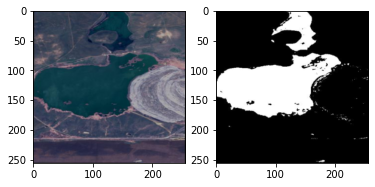

In [7]:
img, mask = train_dataset[0]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))


Burada berlirlediğimiz parametreler denemeler ile değiştirilip denenebilir fakat belirtmeden edemeyeceğim benim GPU'um(RTX 3060) bu veri setini eğitmeye başlayamadı bile. Bu yüzden denemeler yapmayı kendi bilgisayarınızda yapmanızı önermem.

Bunun için Kaggle gerçekten güzel bir hizmet veriyor.

In [8]:
DEVICE='cuda'

EPOCHS=25
BATCH_SIZE=16
LR=0.003
IMAGE_SIZE=320

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

DataLoader kullanılarak modele girdileri hazırlanıyoruz.

In [9]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

Modelimizi hazırlıyoruz...

Burada Unet'in içine encoder'ı ve weights'ı yukarıdaki değişkenlerden belirliyoruz.

Kayıp fonksiyonumuzun değeri, DiceLoss ve BCEWithLogitsLoss'tan çıkan değerlerin toplamıdır.

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [11]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1+loss2
        return logits

Modelimizi derliyoruz ve 'cuda' ile çalışmasını sağlıyoruz.

In [12]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

Eğitim döngüsünde işler daha basite indirgensin diye eğitim ve eval için kullanılacak fonksiyonu şimdiden yazıyoruz.

Kayıplarımızı belirlemek için değeri ilk başta sıfırlıyoruz. Daha sonra fotoğrafları gradiyent olmadan sokup kayıpımızı hesaplıyoruz...

In [13]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0
  for images ,masks in tqdm(data_loader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()

    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()

    return total_loss/len(data_loader)

Burada ise eğitim kısmına benzer bir kayıp hesabı yapıyoruz fakat buradaki önemli işlerden birisi kaybımızı direkt ele alıyor oluşumuz ve no_grad'ın izlenmesidir.

In [14]:
def eval_fn(data_loader,model):
    model.eval()
    total_loss=0.0

    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE)
            masks=masks.to(DEVICE)

            logits,loss=model(images,masks)
            total_loss+=loss.item()

    return total_loss/len(data_loader)


In [15]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

Adam optimizörünü kullanıyoruz ve eğitim döngümüzü kuruyoruz. 

Burada en iyi modeli kaydetmek ve kaybımızı her adımda görmek istiyoruz...

In [16]:
best_val_loss=np.Inf

for i in range(EPOCHS):
  train_loss=train_fn(train_loader,model,optimizer)
  valid_loss=eval_fn(valid_loader,model)

  if valid_loss< best_val_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('Model Saved')
    best_valid_loss=valid_loss
  print(f'Epochs:{i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')

  0%|          | 0/160 [00:00<?, ?it/s]